In [200]:
import pandas as pd
from bokeh.io import output_notebook, reset_output, show
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import pearsonr

from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

from bokeh.layouts import gridplot

In [201]:
reset_output()
output_notebook()

Loading BokehJS ...

In [202]:
SAMPLES_CSV = "./data/multivariate/samples.csv"
GROUND_TRUTH_GML = "./data/multivariate/ground_truth.gml"

In [203]:
df = pd.read_csv(SAMPLES_CSV)
df.head()

,1,2,0,3,4
0,-0.838645,21.325169,-13.760162,83.649314,-816.154097
1,-7.560132,46.409737,4.455981,-21.607153,291.579509
2,12.046033,-86.445286,-11.586864,77.998772,-975.176512
3,1.816280,-14.390608,-9.989630,58.164448,-623.597257
4,10.951982,-70.927503,16.711708,-103.292970,979.593675


In [195]:
# Prepare Data
G = nx.read_gml(GROUND_TRUTH_GML)


#for start_node, end_node, _ in G.edges(data=True):
#    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
#    edge_attrs[(start_node, end_node)] = edge_color

#nx.set_edge_attributes(G, edge_attrs, "edge_color")

# Show with Bokeh
plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("club", "@club")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
#graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)
show(plot, handle_notebook=True)

Identified 5 columns


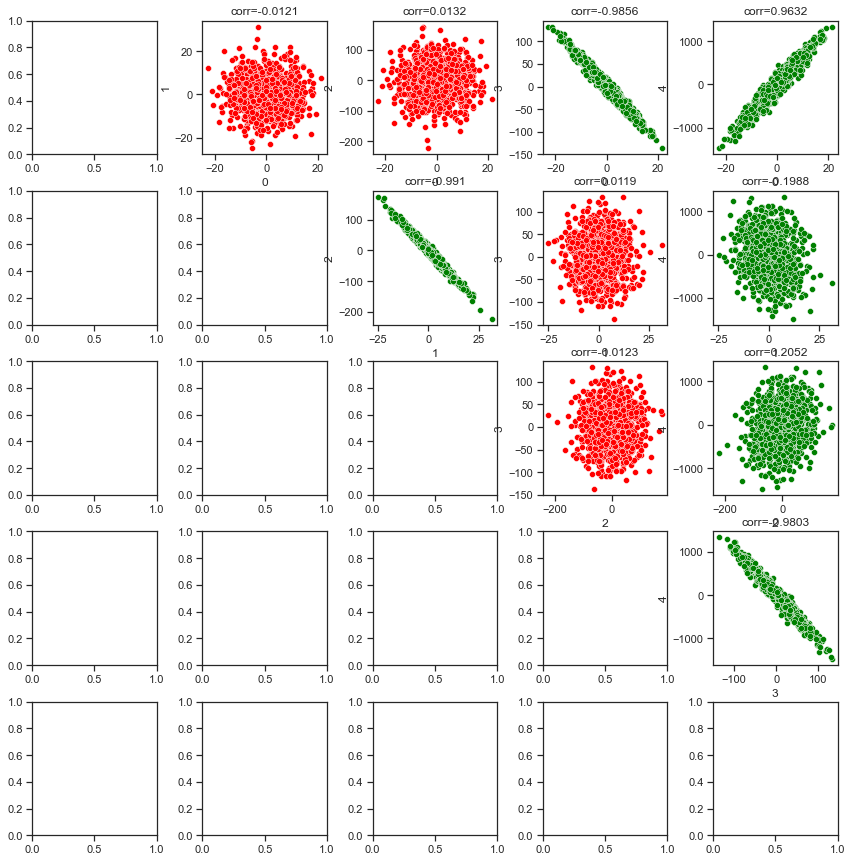

In [206]:
graph = nx.read_gml(GROUND_TRUTH_GML)
expected_edges = [(int(v1), int(v2)) for v1, v2 in list(graph.edges())]
expected_edges

num_cols = len(df.columns)
print(f'Identified {num_cols} columns')

fig, ax = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(12,12))
fig.tight_layout()

for col1 in range(0, num_cols):
    for col2 in range(col1+1, num_cols):
        is_expected_edge = (col1, col2) in expected_edges
        color = 'green' if is_expected_edge else 'red'
        x, y = df[str(col1)], df[str(col2)]
        sns.scatterplot(x=x, y=y, ax=ax[col1, col2], color=color)
        corr = pearsonr(x=x, y=y)
        ax[col1, col2].title.set_text(f'corr={round(corr[0], 4)}')

In [220]:

# create three plots
plots = []
node_max = df.columns[len(df.columns) - 1]
node_min = df.columns[0]

for row_index, row in enumerate(df.columns):
    for column_index, column in enumerate(df.columns):
        
        if column_index > row_index:
            plots.append(None)
            continue

        x_axis_label = f"Node {column}" if row_index == len(df.columns) - 1 else ""
        y_axis_label = f"Node {row}" if column_index == 0 else ""
        # create figure with data
        
        s1 = figure(x_axis_label=x_axis_label, y_axis_label=y_axis_label)
        
        edge = (row, column) in G.edges or (column, row) in G.edges
        
        s1.background_fill_color = "green" if edge else "red"
        s1.background_fill_alpha = 0.05
        
        if column != row:

            x = df[row]
            y = df[column]
            
            edge = (row, column) in G.edges or (column, row) in G.edges
            s1.circle(x, y, size=1, alpha=0.8, color="green" if edge else "red")
            
            s1.circle(x, y, size=1, alpha=0.8, color="#53777a")

            # calculate slope + intercept
            par = np.polyfit(x, y, 1, full=True)
            slope=par[0][0]
            intercept=par[0][1]
            y_predicted = [slope*i + intercept  for i in x]
            s1.line(x,y_predicted,color='red',legend_label=f"Corr: {round(pearsonr(x=x, y=y)[0], 4)}")
        else:
            node = row 
            hist, edges = np.histogram(df[node], density=True, bins=50)
            
            s1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
                   fill_color="navy", line_color="white", alpha=0.5)

            s1.background_fill_color = "white"
            
        plots.append(s1)


# make a grid
grid = gridplot(plots, ncols=len(df.columns), plot_width=250, plot_height=250)

show(grid)